In [1]:
# importing module
import sys
import os
from pathlib import Path
sys.path.append(str(Path.cwd().parent))
from myutils import *
from SLBQP import SLBQP
from datastorer import DataStorer

In [2]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import time
plt.style.use('seaborn')
params = {
    'figure.figsize': (20, 10),
    'legend.fontsize': 'x-large',
    'axes.labelsize': 'x-large',
    'axes.titlesize':'x-large',
    'xtick.labelsize':'x-large',
    'ytick.labelsize':'x-large',
    'axes.titlesize': 'x-large',
}
plt.rcParams.update(params)

In [3]:
seed = None     # random seed
n = 100         # dimension
u = 1.          # upperbound
epsilon = 0.1   #
np.random.seed(seed)

In [4]:
ds = DataStorer()

In [5]:
feat, targ = load_ml_dataset()
t1 = targ[:,0]
t2 = targ[:,1]

loading from: 
/Users/gerardozinno/repos/ProgettoML/cm/data/ML-CUP19-TR.csv


In [6]:
targ = t1
targ

array([ 4.13091198, 29.49904525, 24.14576734, ..., 30.17470543,
       26.4072482 , 14.35999224])

In [7]:
K, target = sample_transform_problem(feat, targ, 100, seed)

In [8]:
problem_sizes = (100, 200, 300, 400, 500)#, 600, 700, 800, 900, 1000)
n_prob = 2
problems = [[sample_transform_problem(feat, targ, size, seed) for size in problem_sizes] for _ in range(n_prob)]

In [9]:
ROSEN = 1
GOLDSTEIN = 2

In [15]:
%%time
prj_type = GOLDSTEIN
sg, xg, vg, itg = SLBQP(K, target, u, epsilon, eps=1e-6, maxIter=-1, lmb0=0, d_lmb=2, prj_eps=1e-9, verbose=False, prj_type=prj_type, ds=ds)


CPU times: user 1.22 s, sys: 112 ms, total: 1.33 s
Wall time: 852 ms


In [ ]:
ds.save_to_file("GOLDSTEIN.csv")
print(f"x: {xg} ({sg})\tv: {vg}\titer: {itg}")

In [11]:
%%time
ds = DataStorer()
prj_type = ROSEN
sr, xr, vr, itr = SLBQP(K, target, u, epsilon, eps=1e-6, maxIter=-1, lmb0=0, d_lmb=2, prj_eps=1e-9, verbose=False, prj_type=prj_type, ds=ds)
ds.save_to_file("ROSEN.csv")
print(f"x: {xr} ({sr})\tv: {vr}\titer: {itr}")

x: [1.         0.57616764 1.         0.         1.         1.
 1.         0.         0.         0.         1.         1.
 1.         0.21102602 0.         1.         1.         0.
 1.         0.         0.         1.         1.         0.
 0.         1.         0.         1.         1.         0.96622871
 0.         0.         0.         0.         0.         0.
 1.         0.         0.         0.         0.         1.
 0.         0.52803965 0.         1.         1.         1.
 0.         0.34874605 1.         1.         0.         1.
 1.         0.         1.         1.         1.         0.
 0.         0.         0.         0.         1.         1.
 1.         0.         0.         0.         0.         0.63599834
 0.         0.         0.         1.         0.         0.
 0.         1.         0.         0.         0.         1.
 1.         0.         1.         1.         1.         0.
 1.         0.         0.         1.         1.         0.
 1.         1.         0.         0. 

In [12]:
np.linalg.norm(vr-vg)

5.9117155615240335e-12

In [13]:
# prj_type = GOLDSTEIN
# goldstein_results = []
# for run in problems:
#    goldstein_temp = []
#    for (K, target) in run:
#        start = time.time()
#        results = (*SLBQP(K, target, u, epsilon, eps=1e-6, maxIter=-1, lmb0=0, d_lmb=2, prj_eps=1e-9, verbose=False, prj_type=prj_type), time.time()-start)
#        goldstein_temp.append(results)
#    goldstein_results.append(goldstein_temp)
    

In [14]:
# TODO risolvere
#averages = []
#for p in goldstein_results:
#    zipped_results = list(zip(*p))
#    for i in (3,4):
#        tmp = []
#        for e in zip(zipped_results):
#            print(e[0][0])

In [15]:
#zipped_results = list(zip(*goldstein_results))
#g_niter = zipped_results[3]
#g_times = zipped_results[4]

In [16]:
#zipped_results

In [17]:
#g_times

NameError: name 'g_niter' is not defined

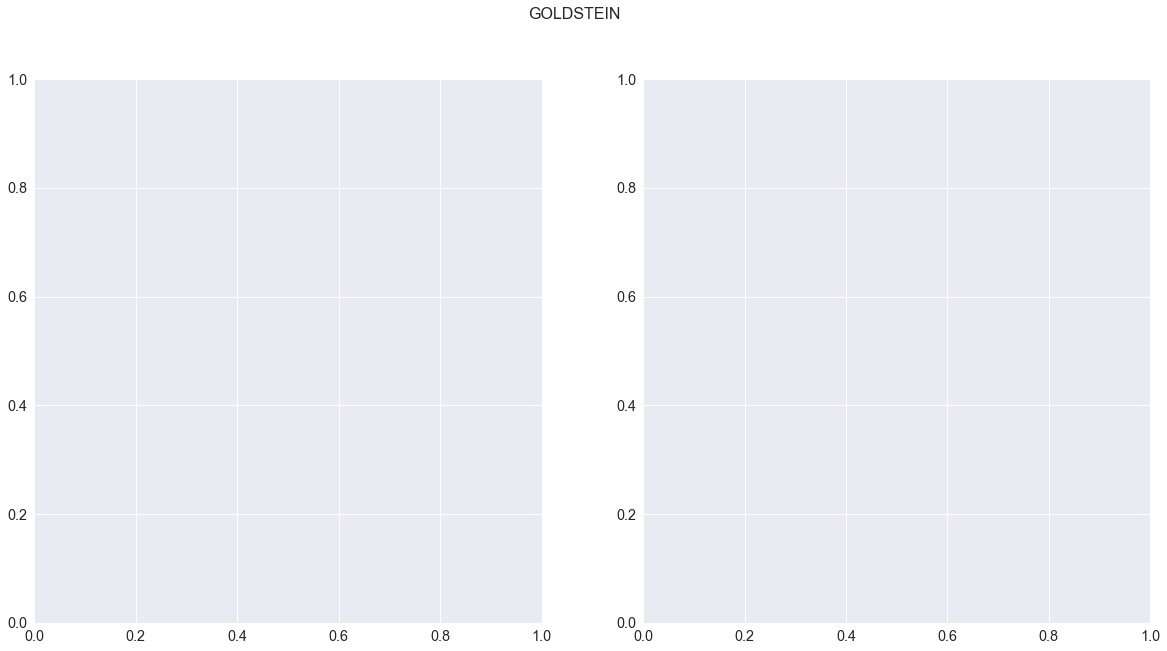

In [18]:
fig, axs = plt.subplots(ncols=2)
fig.suptitle('GOLDSTEIN', fontsize=16)
axs[0].plot(problem_sizes, g_niter, '--o')
axs[0].set_xlabel('problem size')
axs[0].set_ylabel('number of iterations')
axs[1].plot(problem_sizes, g_times, '--o')
axs[1].set_xlabel('problem size')
axs[1].set_ylabel('time (seconds)')
plt.show()

# TODO  
* Calcolare algoritmo su problemi diversi e plottare media
* Vel. conv: prendiamo ottimo risolutore, ad ogni passo plottare valore fun e f* - fi / fi-1 - f*
* Sperimentare con altri parametri
* Confrontare tempi senza numba